## Minimum Regret Search

This notebook can be used to reproduce the results of Section 5.1. of the paper "Minimum Regret Search for Single- and Multi-Task Optimization" (ICML 2016, https://arxiv.org/abs/1602.01064).

Minimum Regret Search (MRS) is a Bayesian optimization method, which
aims at minimizing the expected immediate regret of its ultimate recommendation
for the optimum.  While empirically MRS and the related Entropy Search  perform  similar  in  most  of  the  cases,
MRS  produces  fewer  outliers  with  high  regret  than  ES.  This notebook  provides  empirical  results
on a synthetic single-task optimization problem.

In [1]:
import cPickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

plt.rcParams.update({'axes.labelsize': 11,
                     'axes.titlesize': 12,
                     'text.fontsize': 11,
                     'xtick.labelsize': 8,
                     'ytick.labelsize': 8,
                     'legend.fontsize': 7,
                     'legend.fancybox': True,
                     'font.family': 'serif'})

c = ["r", "g", "b", 'k', 'm', 'c']
ms = ["o", "d", "v", "^", "s", "p"]

from joblib import Parallel, delayed

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic

from bayesian_optimization import (BayesianOptimizer, GaussianProcessModel, 
                                   MinimalRegretSearch, EntropySearch, UpperConfidenceBound,
                                   ExpectedImprovement, ProbabilityOfImprovement,
                                   GPUpperConfidenceBound)
from bayesian_optimization.utils.optimization import global_optimization

/opt/dl/anaconda/envs/bayesopt/lib/python2.7/site-packages/matplotlib/__init__.py:855: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


We will compare different acquisition functions. In order to focus on the differences of the different acquisition functions and preclude other factors, we will use a setting where there is no model mismatch between the (unknown) objective function and the surrogate model used in Bayesian optimization. This can be accomplished by drawing the objective function from a GP with identical kernel as the the GP/kernel used in BO.

In [2]:
def generate_function(kernel, boundaries, n_train_points, random_state):
    """Draws target function from GP."""
    # Create GP prior
    gp_prior = GaussianProcessRegressor(kernel=kernel)
    
    # Sample function from GP by first sampling X values and then
    # sampling the y values for this X values for a specific function
    # from the GP
    X_train = np.random.RandomState(random_state).uniform(
        boundaries[:, 0], boundaries[:, 1], (n_train_points, boundaries.shape[0]))
    y_train = gp_prior.sample_y(X_train, 1, random_state=random_state)

    # Fit GP to the (X, y) samples of the sampled function
    gp_target = GaussianProcessRegressor(kernel=kernel)
    gp_target.fit(X_train, y_train)
    
    # Use the mean of the fitted GP as target function
    def target_fct(x):
        return gp_target.predict(x[np.newaxis, :])[0, 0]
    
    return target_fct

In [3]:
def create_optimizer(kernel, acquisition_function):
    """Create Bayesian optimizer for given GP kernel and acquisition function."""
    model = GaussianProcessModel(kernel=kernel, alpha=1e-3)
    if acquisition_function == "mrs":
        acquisition_function = \
            MinimalRegretSearch(model=model, n_gp_samples=1000, n_candidates=25,
                                n_trial_points=250, n_samples_y=51, point=False)
    if acquisition_function == "mrs_point":
        acquisition_function = \
            MinimalRegretSearch(model=model, n_gp_samples=1000, n_candidates=25,
                                n_trial_points=250, n_samples_y=51, point=True)
    elif acquisition_function == "es":
        acquisition_function = \
            EntropySearch(model=model, n_gp_samples=1000, n_candidates=25,
                          n_trial_points=250, n_samples_y=51)
    elif acquisition_function == "ucb":
        acquisition_function = \
            UpperConfidenceBound(model=model, kappa=5.0)
    elif acquisition_function == "gp_ucb":
        acquisition_function = \
            GPUpperConfidenceBound(model=model, const=0.5)
    elif acquisition_function == "ei":
        acquisition_function = \
            ExpectedImprovement(model=model)
    elif acquisition_function == "pi":
        acquisition_function = \
            ProbabilityOfImprovement(model=model)
    bayes_opt = BayesianOptimizer(model=model, optimizer="direct+lbfgs",
                                  acquisition_function=acquisition_function)
    return bayes_opt

In [4]:
# We do not impose any model mismatch between the GP from which the 
# function was sampled and the GP used internally in Bayesian optimization.
# Moreover, we assume that GP in BO already "knows" the true length scales
kernel = RBF(length_scale=0.1, length_scale_bounds="fixed")
kernel_bo = RBF(length_scale=0.1, length_scale_bounds="fixed")

n_train_points = 250  # used only for sampling the target function
boundaries = np.array([[0.0, 1.0], [0.0, 1.0]])  # Search space

n_runs = 250  # number of independent runs
n_trials = 100  # how many trials (queries) per run are performed
settings = ["mrs", "es", "mrs_point", "ei", "gp_ucb", "pi"]   # acquisition functions

In [5]:
def perform_run(setting, run):
    """Execute a single run of a specific setting."""
    # Make results reproducible by using run index as random seed
    np.random.seed(run)
    
    y_regret = np.empty((n_trials / 5))  # Compute simple regret every 5 steps
    X_dist = np.empty((n_trials / 5)) # Compute distance of recommendation from optimum every 5 steps
    X_query = np.empty((n_trials, boundaries.shape[0]))  # Remember query points
    
    # Generate target function and compute (approximately) its optimum (X_opt) and the 
    # maximal value y_opt
    target_fct = generate_function(kernel, boundaries, n_train_points, random_state=run)
    X_opt = global_optimization(target_fct,  boundaries=boundaries, 
                                optimizer="direct", maxf=1000)
    y_opt = target_fct(X_opt) 

    # Create Bayesian optimizer and perform run
    bayes_opt = create_optimizer(kernel_bo,acquisition_function=setting)
    for i in range(n_trials):
        # Delect query point and generate noisy observation
        query = bayes_opt.select_query_point(boundaries)
        X_query[i] = query
        result = target_fct(query) + 1e-3 * np.random.random()
        # Update Bayesian optimizer
        bayes_opt.update(query, result)
        
        if i % 5 == 4:
            # Every 5 time steps: determine recommendation of 
            # Bayesian optimizer and compute its regret and distance to optimum
            X_sel = global_optimization(lambda x: bayes_opt.model.gp.predict(x[np.newaxis, :]), 
                                        boundaries=boundaries, 
                                        optimizer="direct", maxf=1000)
            y_sel = target_fct(X_sel)

            y_regret[i / 5] = y_opt - y_sel
            X_dist[i / 5] = np.sqrt(((X_opt - X_sel)**2).sum())
    
    # Store results of individual runs in a log file (not stricly necessary)
    f = open("log/%s_%s" % (setting, run), 'w')
    cPickle.dump((setting, run, y_regret, X_dist, X_query), f, protocol=-1)
    f.close()
    return setting, run, y_regret, X_dist, X_query

In [6]:
# Since the actual experiment takes quite long, we default to loading 
# results from disk from a prior execution of the experiment (the one reported
# in the paper). 
load_results = True

if not load_results:  # actually perform experiment
    # Run the experiment parallel (multiple threads on one machine)
    n_jobs = 1 # how many parallel threads
    res = Parallel(n_jobs=n_jobs, verbose=10)(
            delayed(perform_run)(setting, run)
                for run in range(90, n_runs)
                    for setting in settings)

    # Extract the simple regrets, the distance from optimum, and where 
    # the runs have performed queries
    y_regret = np.empty((len(settings), n_runs, n_trials / 5))
    X_dist = np.empty((len(settings), n_runs, n_trials / 5))
    X_query = np.empty((len(settings), n_runs, n_trials, 2))
    for setting, run, y_regret_, X_dist_, X_query_ in res:
        i = settings.index(setting)
        y_regret[i, run] = y_regret_
        X_dist[i, run] = X_dist_
        X_query[i, run] = X_query_
      
    # This would store the results:
    # f = open("icml_2016_res.pickle", "w")
    # cPickle.dump((y_regret, X_dist, X_query), f)
    # f.close()
else:  # load results
    f = open("icml_2016_res.pickle", "r")
    y_regret, X_dist, X_query = cPickle.load(f)
    f.close()

### Plotting
Generate plots of Figure 2 of the paper

In [7]:
setting_names = {
    "mrs": "MRS",
    "es": "ES",
    "mrs_point": r"MRS$^{point}$",
    "ei": "EI",
    "gp_ucb": "GP-UCB",
    "pi": "PI"
}

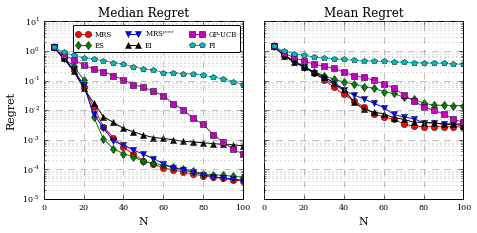

In [8]:
## Simple regret over number of queries

fig_width = 487.8225 / 72.27  # Get fig_width_pt from LaTeX using \showthe\columnwidth
fig_height = fig_width * 0.5  # height in inches
plt.figure(0, dpi=400, figsize=(fig_width, fig_height))

ax = plt.subplot(1,2,1)
for i, setting in enumerate(settings):
    ax.plot(np.arange(5, n_trials+1, 5), np.median(y_regret[i], 0), 
            c=c[i], marker=ms[i], label=setting_names[setting])
ax.set_ylim(1e-5, 1e1)
#ax.tick_params(axis='y', which='minor')
#ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.set_yscale("log")
ax.set_xlabel("N")
ax.set_ylabel("Regret")
ax.grid(b=True, which='major', color='gray', linestyle='--')
ax.grid(b=True, which='minor', color='gray', linestyle=':')
ax.legend(loc="best", ncol=3, )
ax.set_title("Median Regret")

ax = plt.subplot(1,2,2)
for i, setting in enumerate(settings):
    ax.plot(np.arange(5, n_trials+1, 5), np.mean(y_regret[i], 0), 
            c=c[i], marker=ms[i], label=setting_names[setting])
ax.set_ylim(1e-5, 1e1)
ax.set_yscale("log")
ax.set_xlabel("N")
ax.set_yticklabels([])
ax.grid(b=True, which='major', color='gray', linestyle='--')
ax.grid(b=True, which='minor', color='gray', linestyle=':')
ax.set_title("Mean Regret")

plt.tight_layout()

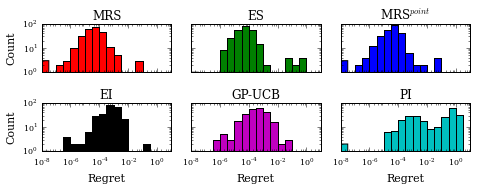

In [9]:
# Histograms of simple regrets over runs

fig_width = 487.8225 / 72.27  # Get fig_width_pt from LaTeX using \showthe\columnwidth
fig_height = fig_width * 0.4  # height in inches
plt.figure(0, dpi=400, figsize=(fig_width, fig_height))

for i, setting in enumerate(settings):
    ax = plt.subplot(2, 3, i+1)
    ax.hist(np.maximum(y_regret[i, : , -1], 1e-8), #normed=True,
            bins=np.logspace(-8, 1, 19), color=c[i])
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(setting_names[setting])
    ax.set_xticks([1e-8, 1e-6, 1e-4, 1e-2, 1e0])
    if i % 3 != 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("Count")
    if i < 3:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Regret")
plt.tight_layout()

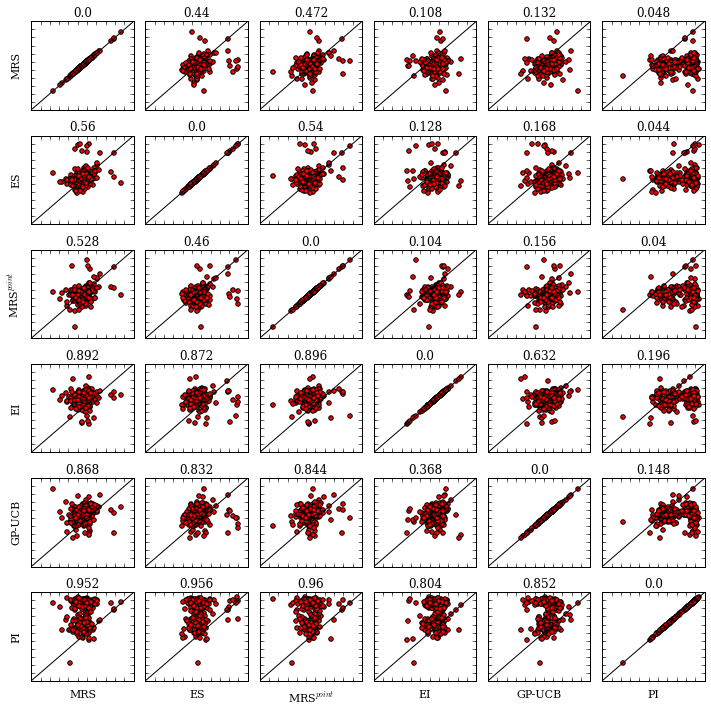

In [10]:
## Scatter plot of simple regrets for pairs of acquisition functions

plt.figure(figsize=(10, 10))
for i in range(len(settings)):
    for j in range(len(settings)):
        plt.subplot(len(settings), len(settings), j*len(settings) + i + 1)
        plt.scatter(y_regret[i, :, -1], y_regret[j, :, -1], c='r')
        plt.xscale("log")
        plt.yscale("log")
        plt.xlim(1e-10, 1e1)
        plt.ylim(1e-10, 1e1)
        plt.plot([1e-10, 1e1], [1e-10, 1e1], c='k')
        if j == len(settings) - 1:
            plt.xlabel(setting_names[settings[i]])
        plt.gca().set_xticklabels([])
        if i == 0:
            plt.ylabel(setting_names[settings[j]])
        plt.gca().set_yticklabels([])
        plt.title(str((y_regret[i, : , -1] < y_regret[j, : , -1]).mean()))
plt.tight_layout()

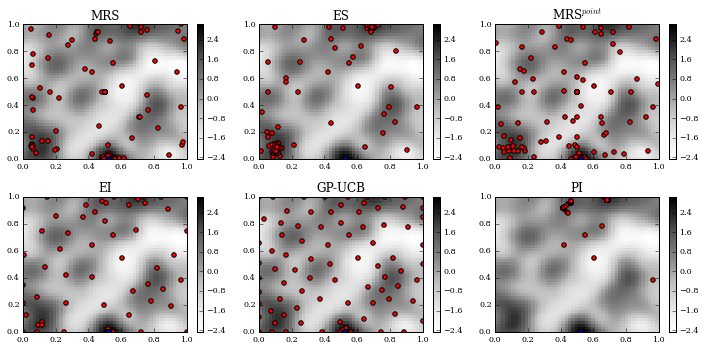

In [11]:
# Visualize target function and where different acquisition functions
# have performed queries

run = 218 

kernel = RBF(length_scale=0.1, length_scale_bounds="fixed")

n_train_points = 250
boundaries = np.array([[0.0, 1.0], [0.0, 1.0]])
target_fct = generate_function(kernel, boundaries, n_train_points, random_state=run)
X_opt = global_optimization(target_fct,  boundaries=boundaries, 
                            optimizer="direct", maxf=5000)

x_ = np.linspace(0, 1, 50)
y_ = np.linspace(0, 1, 49)
X_, Y_ = np.meshgrid(x_, y_)
Z_ = [[target_fct(np.array([x_[i], y_[j]]))
       for i in range(x_.shape[0])] 
      for j in range(y_.shape[0])]

plt.figure(figsize=(10, 5))
for i in range(len(settings)):
    plt.subplot(2, 3, i+1)
    plt.pcolor(X_, Y_, np.array(Z_), cmap = cm.Greys)
    plt.colorbar()
    plt.scatter(X_query[i, run, :, 0], X_query[i, run, :, 1], c='r')
    plt.scatter(X_opt[[0]], X_opt[1], c='b')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title(setting_names[settings[i]])
plt.tight_layout()

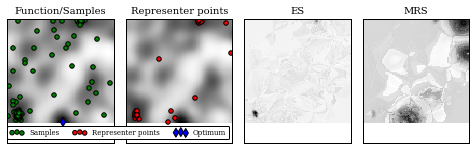

In [12]:
## Generate Figure 3 of paper

np.random.seed(0)

setting_index = 1
run = y_regret[setting_index, :, -1].argmax()

target_fct = generate_function(kernel, boundaries, n_train_points, random_state=run)
X_opt = global_optimization(target_fct,  boundaries=boundaries, 
                            optimizer="direct", maxf=5000)

model = GaussianProcessModel(kernel=kernel, alpha=1e-3)
y = [target_fct(X_query[1, run, i]) for i in range(100)]
model.fit(X_query[1, run], y)

n_gp_samples = 1000

mrs = MinimalRegretSearch(model=model, n_gp_samples=n_gp_samples, n_candidates=25,
                          n_trial_points=250, n_samples_y=51, point=False)
mrs.set_boundaries(boundaries)
es = EntropySearch(model=model, n_gp_samples=n_gp_samples, n_candidates=25, 
                   n_trial_points=250, n_samples_y=51)
es.set_boundaries(boundaries, X_candidate=mrs.X_candidate)

x_ = np.linspace(0, 1, 100)
y_ = np.linspace(0, 1, 100)
X_, Y_ = np.meshgrid(x_, y_)

# True function
Z_ = [[target_fct(np.array([x_[i], y_[j]]))
       for i in range(x_.shape[0])] 
      for j in range(y_.shape[0])]

fig_width = 487.8225 / 72.27 # Get fig_width_pt from LaTeX using \showthe\columnwidth
fig_height = fig_width * 0.33  # height in inches
plt.figure(0, dpi=400, figsize=(fig_width, fig_height))

ax = plt.subplot(1, 4, 1)
ax.set_axis_bgcolor('white')
plt.pcolor(X_, Y_, np.array(Z_), cmap = cm.Greys)
#plt.colorbar()
samples = plt.scatter(X_query[setting_index, run, :, 0], X_query[setting_index, run, :, 1],
                      alpha=1.0, c='g', marker='o', label="Samples")
optimum = plt.scatter(X_opt[[0]], X_opt[1],
                      alpha=1.0, c='b', marker='d', s=40, label="Optimum")
plt.xlim(0, 1)
plt.ylim(-0.2, 1)
plt.xticks([])
plt.yticks([])
plt.title("Function/Samples", fontsize=10)

ax = plt.subplot(1, 4, 2)
ax.set_axis_bgcolor('white')
plt.pcolor(X_, Y_, np.array(Z_), cmap = cm.Greys)
repr_points = plt.scatter(mrs.X_candidate[:, 0], mrs.X_candidate[:, 1], 
                          alpha=1.0, c='r', label="Representer points")
plt.legend(handles=[samples, repr_points, optimum], loc="lower right", ncol=3)
plt.xlim(0, 1)
plt.ylim(-0.2, 1)
plt.xticks([])
plt.yticks([])
plt.title("Representer points", fontsize=10)

for index, acq in enumerate([es, mrs]):
    ax = plt.subplot(1, 4, index+3)
    ax.set_axis_bgcolor('white')
    Z_ = [[acq(np.array([x_[i], y_[j]]))[0]
       for i in range(x_.shape[0])] 
      for j in range(y_.shape[0])]

    plt.pcolor(X_, Y_, np.array(Z_), cmap = cm.Greys)
    #plt.colorbar()
    plt.xlim(0, 1)
    plt.ylim(-0.2, 1)
    plt.xticks([])
    plt.yticks([])
    plt.title(["ES", "MRS"][index], fontsize=10)

    plt.tight_layout()